## Modeling

#### Introduction

This notebook presents the process of building a machine learning model. We will start with a simple approach, employing basic imputation and encoding techniques, along with default parameter settings for the Random Forest model. The objective is to establish a baseline model from which we can assess the efficacy of subsequent feature engineering, model selection, and hyperparameter tuning efforts.

#### Steps

1. **Data Loading and Preliminary Exploration**:
   - Load the dataset containing the features and target variable.
   - Perform initial data exploration to understand the structure and nature of the data.

2. **Data Preprocessing**:
   - Handle missing values using a simpler imputer strategy, such as mean or median imputation.
   - Encode categorical variables using a basic encoding method, like one-hot encoding or label encoding.

3. **Baseline Model Training**:
   - Split the data into training and testing sets.
   - Initialize a Random Forest classifier with default hyperparameters.
   - Train the model on the training data.

4. **Baseline Model Evaluation**:
   - Evaluate the baseline model's performance on the testing data using appropriate metrics such as accuracy, precision, recall, and F1-score.
   - Visualize the results to gain insights into the model's performance.

5. **Iterative Improvement**:
   - Based on the evaluation results, identify potential areas for improvement, such as feature selection or hyperparameter tuning.
   - Implement iterative enhancements to the model and evaluate the impact on performance.

6. **Summary and Next Steps**:
   - Summarize the findings from the baseline model and any subsequent improvements.
   - Outline potential next steps for further refining the model and achieving better predictive performance.

By following these steps, we aim to develop a robust machine learning pipeline that can effectively tackle the predictive task at hand, starting with a simple baseline model and progressively enhancing its performance through iterative refinement.

---


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../src')

from src.model.train import MLFlowBayesianTuner
from skopt.space import Real, Integer, Categorical

import pandas as pd

from src.utils.utils import get_column_types
from src.utils.plots import plot_roc_curve, plot_feature_importance

from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

import warnings
import os
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

import mlflow
mlflow.set_tracking_uri('../mlruns')

In [3]:
df_bureau_features = pd.read_csv('../data/tables/bureau_features.csv')
df_application_train = pd.read_csv('../data/tables/application_train.csv')

I read the **training and the features tables**, to get the new features for the training set I need to merge them as follows:

In [4]:
df_train = df_application_train.merge(df_bureau_features, 'left', 'SK_ID_CURR')

X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
y = df_train['TARGET']

In [5]:
numerical_cols, categorical_cols  = get_column_types(X,2)

Numerical columns: 110 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINE


Since the data is **imbalanced**, let's calculate the class weights using the proportions to incorporate this information into the random forest model.

In [6]:
proportion_positive_samples = y.mean()
imbalance_ratio = (1 - proportion_positive_samples)/ proportion_positive_samples
class_weights = {0: 1, 1: imbalance_ratio}
class_weights

{0: 1, 1: 11.387150050352467}

In [7]:
rf = RandomForestClassifier(class_weight = class_weights, n_jobs=-1)

categorical_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                                   ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_pipe, categorical_cols),
        ('num', SimpleImputer(strategy='mean'), numerical_cols)
    ],
    remainder='passthrough'
)       
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', rf)])


scores = cross_val_predict(rf_model, X, y, cv=3, method='predict_proba', n_jobs=-1)

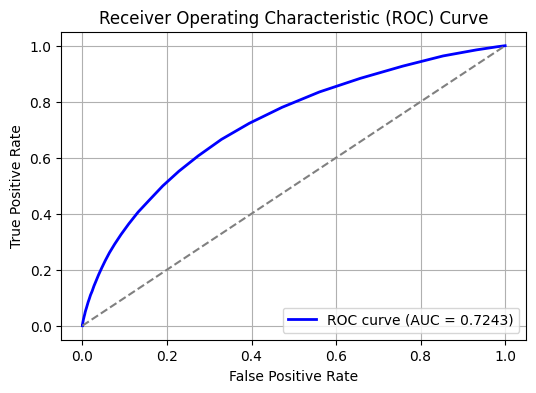

In [8]:
plot_roc_curve(y,scores[:,1])

In [7]:
df_application_test = pd.read_csv('../data/tables/application_test.csv')
df_test = df_application_test.merge(df_bureau_features, 'left', 'SK_ID_CURR')
X_test = df_test.drop(['SK_ID_CURR'], axis = 1)

In [28]:
rf_model.fit(X,y)
yhat_train = rf_model.predict_proba(X)
yhat = rf_model.predict_proba(X_test)

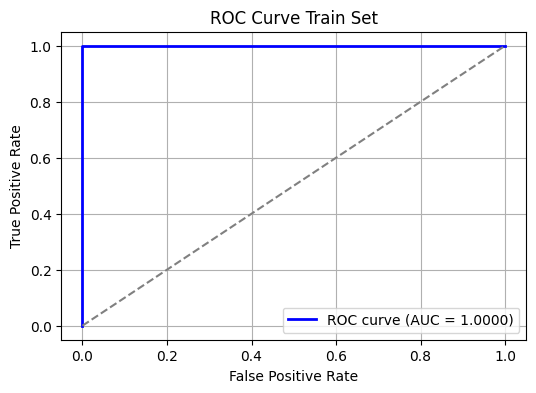

In [32]:
plot_roc_curve(y,yhat_train[:,1], title = 'ROC Curve Train Set')

In [34]:
target = pd.Series(yhat[:,1], name='TARGET')
base_line_submission = pd.concat([df_test['SK_ID_CURR'], target], axis = 1)
base_line_submission.to_csv('../data/tables/base_line_submission.csv', index=False)
base_line_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.09
1,100005,0.08
2,100013,0.02
3,100028,0.04
4,100038,0.16


### Summary

In the initial phase of modeling, I established a baseline model and evaluated its performance using cross-validation.

**Baseline Model Evaluation:**

- The model achieved an AUC of 0.725 during cross-validation.
- However, on the training set, it exhibited perfect classification with an AUC of 1.

**Key Observations:**

From the evaluation, several observations can be made:

1. **Overfitting with Default Parameters:**
   - The baseline model appears to suffer from overfitting as indicated by the significant disparity between the performance on the training set and cross-validation.
   
2. **Memorization of Training Set:**
   - The model's perfect AUC score on the training set suggests that it has memorized the data rather than generalizing from it.

**Test Set Evaluation:**

- Furthermore, predictions were computed for the test set, and a submission file was generated for Kaggle competition.
- The model achieved a private score of 0.7171 on the test set.

**Next Steps:**

Based on the findings, the following steps are recommended for further improvement:

- **Algorithm Selection and Parameter Tuning:**
  - Explore alternative algorithms and parameter settings to mitigate overfitting and enhance model performance.

- **Alternative Imputation Techniques:**
  - Consider adopting different techniques for handling missing values to potentially improve model robustness.

By addressing these aspects, I aim to develop a more robust and generalizable predictive model for the task at hand.


In [8]:
categorical_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                                   ('encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
                                   ]
                            )

preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_pipe, categorical_cols),
        ('num', SimpleImputer(strategy='mean'), numerical_cols)
    ],
    remainder='passthrough'
)  

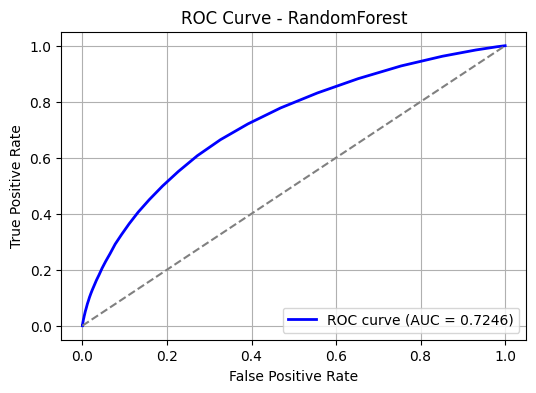

In [8]:
rf = RandomForestClassifier(class_weight = class_weights, n_jobs=-1, random_state=42)   
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', rf)])

param_space= {
    'classifier__n_estimators': Integer(10, 300),  # Number of trees in the forest
    'classifier__criterion':Categorical(['gini', 'entropy', 'log_loss']),
    'classifier__max_depth': Categorical([None] + list(range(2, 40))),         # Maximum depth of the trees
    'classifier__min_samples_split': Integer(2, 20), # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': Integer(1, 20),  # Minimum number of samples required to be at a leaf node
    'classifier__max_features': Real(0.1, 1.0),      # Number of features to consider when looking for the best split
    'classifier__max_leaf_nodes': Categorical([None] + list(range(2, 40))),    # Maximum number of leaf nodes in each tree
    'classifier__min_impurity_decrease': Real(0.0, 0.5),  # Minimum impurity decrease required for a split
    'classifier__bootstrap': Categorical([True, False])  # Whether bootstrap samples are used when building trees
}
trainer = MLFlowBayesianTuner(rf_model)

trainer.tune_model(
    X,y,
    param_space,
    run_name='RandomForest',
    cv=3,
    n_iter = 10,
    n_jobs=-1,
)

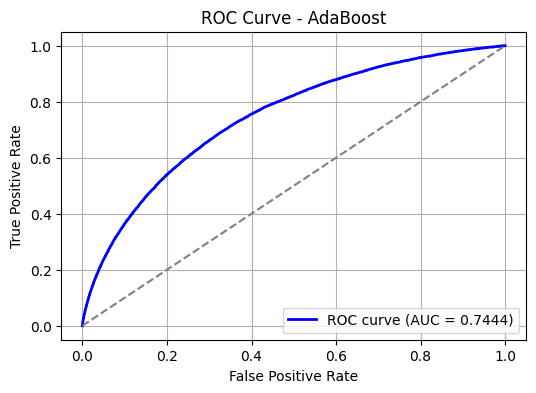

In [9]:
ada = AdaBoostClassifier(random_state=42)   
ada_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', ada)])
param_space = {
    'classifier__n_estimators': Integer(10, 300),  # Number of estimators (trees) in the ensemble
    'classifier__learning_rate': Real(0.01, 1.0),   # Learning rate for the AdaBoost algorithm
    'classifier__algorithm': Categorical(['SAMME', 'SAMME.R']),  # AdaBoost algorithm to use
}

trainer = MLFlowBayesianTuner(ada_model)

trainer.tune_model(
    X,y,
    param_space,
    run_name='AdaBoost',
    cv=3,
    n_iter = 10,
    n_jobs=-1,
)

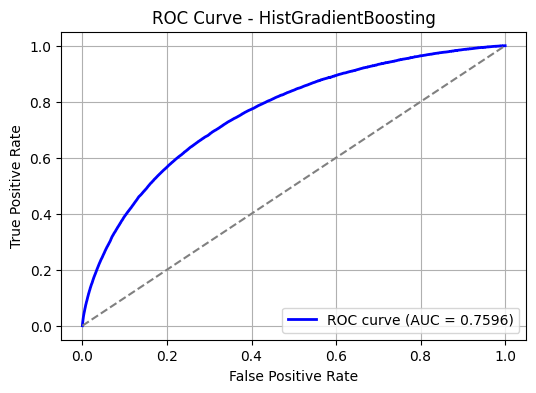

In [10]:
hgb = HistGradientBoostingClassifier(class_weight = class_weights, random_state=42)   
HGB_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', hgb)])


param_space = {
    'classifier__learning_rate': Real(0.01, 1.0),                   # Learning rate for gradient boosting
    'classifier__max_iter': Integer(10, 600),                      # Maximum number of boosting iterations
    'classifier__max_leaf_nodes':Categorical([None] + list(range(2, 31))),                   # Maximum number of leaf nodes
    'classifier__max_depth': Categorical([None] + list(range(2, 21))),  # Maximum depth of individual trees
    'classifier__min_samples_leaf': Integer(2, 20),                # Minimum number of samples required to be at a leaf node
    'classifier__l2_regularization': Real(0.0, 2),               # L2 regularization term
    'classifier__max_features': Real(0.01, 1.0),                    # Maximum proportion of features to consider
    'classifier__max_bins': Integer(50, 255),                      # Maximum number of bins for histograms
    'classifier__interaction_cst': Categorical(['pairwise', 'no_interactions']),            # Whether to use early stopping to terminate training when validation score is not improving
    'classifier__tol': Real(1e-08, 1e-06)                          # Tolerance for the early stopping criterion
}


trainer = MLFlowBayesianTuner(HGB_model)

trainer.tune_model(
    X,y,
    param_space,
    run_name='HistGradientBoosting',
    cv=3,
    n_iter = 50,
    n_jobs=-1,
)

In [9]:
df_credit_card_balance_features = pd.read_csv('../data/tables/credit_card_balance_features.csv')
df_train = df_train.merge(df_credit_card_balance_features, 'left', 'SK_ID_CURR')


X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
y = df_train['TARGET']

In [10]:
numerical_cols, categorical_cols  = get_column_types(X,2)

Numerical columns: 129 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINE

In [11]:
preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_pipe, categorical_cols),
        ('num', SimpleImputer(strategy='mean'), numerical_cols)
    ],
    remainder='passthrough'
)  

hgb = HistGradientBoostingClassifier(class_weight = class_weights, random_state=42)   
HGB_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', hgb)])

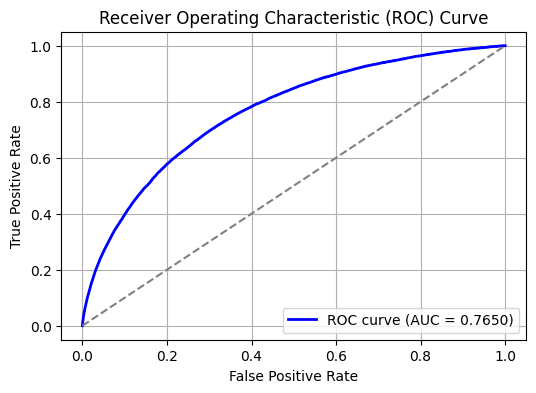

In [14]:
scores = cross_val_predict(HGB_model, X, y, cv=3, method='predict_proba', n_jobs=-1)
plot_roc_curve(y,scores[:,1])

In [12]:
df_test = df_test.merge(df_credit_card_balance_features, 'left', 'SK_ID_CURR')
X_test = df_test.drop(['SK_ID_CURR'], axis = 1)
X_test.shape

(48744, 177)

In [ ]:
HGB_model.fit(X,y)
yhat = HGB_model.predict_proba(X_test)

In [20]:
target = pd.Series(yhat[:,1], name='TARGET')
hgb_credi_card_features = pd.concat([df_test['SK_ID_CURR'], target], axis = 1)
hgb_credi_card_features.to_csv('../data/tables/submission_hgb_credi_card_features.csv', index=False)
hgb_credi_card_features.head()

,SK_ID_CURR,TARGET
0,100001,0.271764
1,100005,0.569127
2,100013,0.190850
3,100028,0.375121
4,100038,0.676198


In [13]:
df_previous_application_features = pd.read_csv('../data/tables/previous_application_features.csv')
df_train = df_train.merge(df_previous_application_features, 'left', 'SK_ID_CURR')


X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
y = df_train['TARGET']
X.shape

(307511, 353)

In [20]:
df_test = df_test.merge(df_previous_application_features, 'left', 'SK_ID_CURR')
X_test = df_test.drop(['SK_ID_CURR'], axis = 1)
X_test.shape

(48744, 353)

In [14]:
numerical_cols, categorical_cols  = get_column_types(X,2)

Numerical columns: 304 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINE

In [16]:
preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_pipe, categorical_cols),
        ('num', SimpleImputer(strategy='mean'), numerical_cols)
    ],
    remainder='passthrough'
)  

hgb = HistGradientBoostingClassifier(class_weight = class_weights, random_state=42)   
HGB_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', hgb)])

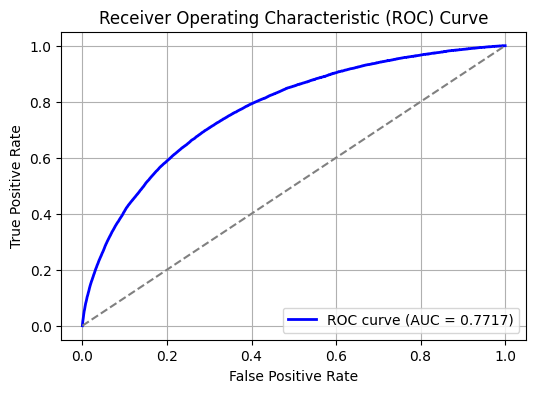

In [17]:
scores = cross_val_predict(HGB_model, X, y, cv=3, method='predict_proba', n_jobs=-1)
plot_roc_curve(y,scores[:,1])

In [18]:
df_POS_CASH_balance_features = pd.read_csv('../data/tables/POS_CASH_balance_features.csv')
df_installments_payments_features = pd.read_csv('../data/tables/installments_payments_features.csv')

df_train = df_train.merge(df_POS_CASH_balance_features, 'left', 'SK_ID_CURR')

df_train = df_train.merge(df_installments_payments_features, 'left', 'SK_ID_CURR')
df_train.to_csv('../data/tables/final_train_set.csv', index=False)

X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
y = df_train['TARGET']
X.shape

(307511, 377)

In [22]:
df_test = df_test.merge(df_POS_CASH_balance_features, 'left', 'SK_ID_CURR')
df_test = df_test.merge(df_installments_payments_features, 'left', 'SK_ID_CURR')

df_test.to_csv('../data/tables/final_test_set.csv', index=False)

X_test = df_test.drop(['SK_ID_CURR'], axis = 1)
X_test.shape

(48744, 377)

In [23]:
numerical_cols, categorical_cols  = get_column_types(X,2)

Numerical columns: 328 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINE

In [24]:
preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_pipe, categorical_cols),
        ('num', SimpleImputer(strategy='mean'), numerical_cols)
    ],
    remainder='passthrough'
)  

hgb = HistGradientBoostingClassifier(class_weight = class_weights, random_state=42)   
HGB_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', hgb)])

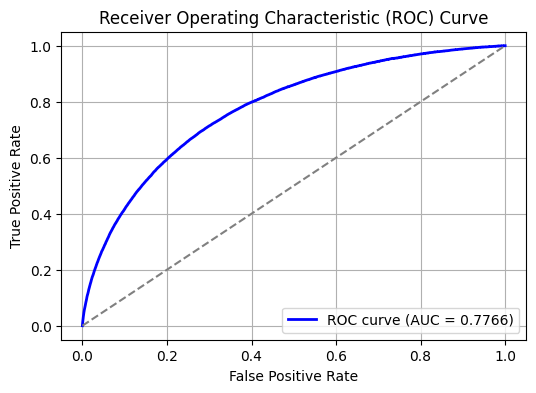

In [25]:
scores = cross_val_predict(HGB_model, X, y, cv=3, method='predict_proba', n_jobs=-1)
plot_roc_curve(y,scores[:,1])